In [6]:
from transformers import BertModel, BertTokenizer
from datasets import load_dataset
import torch.nn as nn

# Load the SWDA dataset
swda = load_dataset("swda")
swda = swda.remove_columns(['swda_filename', 'ptb_basename', 'transcript_index', 'act_tag', 'caller', 'utterance_index', 'subutterance_index', 'pos', 'trees', 'ptb_treenumbers', 'talk_day', 'length', 'topic_description', 'prompt', 'from_caller', 'from_caller_sex', 'from_caller_education', 'from_caller_birth_year', 'from_caller_dialect_area', 'to_caller', 'to_caller_sex', 'to_caller_education', 'to_caller_birth_year', 'to_caller_dialect_area'])
swda = swda.rename_column("damsl_act_tag", "label")
swda



Found cached dataset swda (/Users/mangrove/.cache/huggingface/datasets/swda/default/0.0.0/9af7f63229aca2a0d84408dd35ceb640b18d13f36d4b6e668f577905f6339ec0)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['conversation_no', 'label', 'text'],
        num_rows: 213543
    })
    validation: Dataset({
        features: ['conversation_no', 'label', 'text'],
        num_rows: 56729
    })
    test: Dataset({
        features: ['conversation_no', 'label', 'text'],
        num_rows: 4514
    })
})

Found cached dataset swda (/Users/mangrove/.cache/huggingface/datasets/swda/default/0.0.0/9af7f63229aca2a0d84408dd35ceb640b18d13f36d4b6e668f577905f6339ec0)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['conversation_no', 'label', 'text'],
        num_rows: 213543
    })
    validation: Dataset({
        features: ['conversation_no', 'label', 'text'],
        num_rows: 56729
    })
    test: Dataset({
        features: ['conversation_no', 'label', 'text'],
        num_rows: 4514
    })
})

Found cached dataset swda (/Users/mangrove/.cache/huggingface/datasets/swda/default/0.0.0/9af7f63229aca2a0d84408dd35ceb640b18d13f36d4b6e668f577905f6339ec0)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['conversation_no', 'label', 'text'],
        num_rows: 213543
    })
    validation: Dataset({
        features: ['conversation_no', 'label', 'text'],
        num_rows: 56729
    })
    test: Dataset({
        features: ['conversation_no', 'label', 'text'],
        num_rows: 4514
    })
})

In [70]:
import re 

def clean_swda_utterance(text):
    text = re.sub(r'\[.*?\]', '', text)
    text = text.strip()
    text = re.sub(r'\(.*?\)', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.lower()
    text = ' '.join(text.split())
    return {"text": text}


In [71]:
swda = swda.map(lambda x : clean_swda_utterance(x['text']))

  0%|          | 0/213543 [00:00<?, ?ex/s]

  0%|          | 0/56729 [00:00<?, ?ex/s]

  0%|          | 0/4514 [00:00<?, ?ex/s]

In [74]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [72]:
import torch
from torch.utils.data import DataLoader, Dataset


class SWDADataset(Dataset):
    def __init__(self, swda, tokenizer, max_seq_length):
        self.swda = swda
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.swda)

    def __getitem__(self, index):
        # Get input text
        input_text = self.tokenizer.encode_plus(
            self.swda[index]['text'],
            add_special_tokens=True,
            max_length=self.max_seq_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Get context
        context = self.swda[index-1] if index > 0 else self.swda[index]
        context = self.tokenizer.encode_plus(
            context['text'],
            add_special_tokens=True,
            max_length=self.max_seq_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Get label
        label = self.swda[index]['label']
        
        return input_text, context, label


# Create the train loader
train_dataset = SWDADataset(swda['train'], tokenizer, max_seq_length=128)
val_dataset = SWDADataset(swda['validation'], tokenizer, max_seq_length=128)
test_dataset = SWDADataset(swda['test'], tokenizer, max_seq_length=128)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [77]:
class BertLSTM(nn.Module):
    def __init__(self, num_labels, hidden_size, lstm_layers, dropout_rate):
        super(BertLSTM, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        for param in self.bert.parameters():
            param.requires_grad = False
        self.dropout = nn.Dropout(dropout_rate)
        self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_size,
                            num_layers=lstm_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        bert_outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        
        # Use the hidden states from the last layer of BERT
        hidden_states = bert_outputs[0] 
        
        # Apply dropout to the hidden states
        hidden_states = self.dropout(hidden_states)
        
        # Pass the hidden states through the LSTM
        lstm_output, _ = self.lstm(hidden_states)
        
        # Apply dropout to the LSTM output
        lstm_output = self.dropout(lstm_output)
        
        # Get the last hidden state of the LSTM for classification
        lstm_last_hidden = lstm_output[:, -1, :]
        
        # Pass the last hidden state through the fully connected layer
        logits = self.fc(lstm_last_hidden)
        
        return logits

model = BertLSTM(num_labels=43, hidden_size=512, lstm_layers=2, dropout_rate=0.2)
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [78]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [79]:
train_losses = []
val_losses = []

train_labels = []
val_labels = []

train_accuracies = [] 
val_accuracies = []

num_epochs = 6

best_val_loss = float('inf')
for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for i, (input_text, context, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        input_text = {
            'input_ids': input_text['input_ids'].squeeze(1),
            'attention_mask': input_text['attention_mask'].squeeze(1),
            'token_type_ids': input_text['token_type_ids'].squeeze(1)
        }
        labels = labels.to(device)
        output = model(input_ids=input_text['input_ids'].squeeze(1), 
                       attention_mask=input_text['attention_mask'].squeeze(1), 
                       token_type_ids=input_text['token_type_ids'].squeeze(1))
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * input_text["input_ids"].size(0)

        # Compute accuracy for this batch
        predicted_labels = output.argmax(dim=1)
        num_correct = (predicted_labels == labels).sum().item()
        acc = num_correct / len(labels)
        epoch_acc += acc
        
        
        if (i+1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}')

    # Compute average loss and accuracy for epoch
    epoch_loss /= len(train_loader)
    epoch_acc /= len(train_loader)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)


    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    
    # Validation loop
    print("Validation")
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for j, (input_text, context, labels) in enumerate(val_loader):
            
            input_text = {
            'input_ids': input_text['input_ids'].squeeze(1),
            'attention_mask': input_text['attention_mask'].squeeze(1),
            'token_type_ids': input_text['token_type_ids'].squeeze(1)
            }
            labels = labels.to(device)
            output = model(input_ids=input_text['input_ids'].squeeze(1), 
                       attention_mask=input_text['attention_mask'].squeeze(1), 
                       token_type_ids=input_text['token_type_ids'].squeeze(1))
            loss = criterion(output, labels)

            val_loss += loss.item() * input_text["input_ids"].size(0)

            # Compute accuracy for this batch
            predicted_labels = output.argmax(dim=1)
            num_correct = (predicted_labels == labels).sum().item()
            acc = num_correct / len(labels)
            val_acc += acc

            if (j+1) % 1000 == 0:
                print(f'Epoch val [{epoch+1}/{num_epochs}]')

    # Compute average validation loss and accuracy
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc /= len(val_loader)
    val_accuracies.append(val_acc)

    
    print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'bert_lstm_final.pt')


Epoch [1/6], Step [1000/6674], Train Loss: 1.1376
Epoch [1/6], Step [2000/6674], Train Loss: 1.2129
Epoch [1/6], Step [3000/6674], Train Loss: 1.4544
Epoch [1/6], Step [4000/6674], Train Loss: 1.0975
Epoch [1/6], Step [5000/6674], Train Loss: 0.9823
Epoch [1/6], Step [6000/6674], Train Loss: 0.7709
Epoch 1/6, Loss: 37.5756, Accuracy: 0.6348
Validation
Epoch val [1/6]
Epoch val [1/6]
Epoch val [1/6]
Epoch val [1/6]
Epoch val [1/6]
Epoch val [1/6]
Epoch 1/6, Val Loss: 32.8526, Val Accuracy: 0.6773
Epoch [2/6], Step [1000/6674], Train Loss: 0.5130
Epoch [2/6], Step [2000/6674], Train Loss: 0.4327
Epoch [2/6], Step [3000/6674], Train Loss: 0.6151
Epoch [2/6], Step [4000/6674], Train Loss: 0.8228
Epoch [2/6], Step [5000/6674], Train Loss: 0.8097
Epoch [2/6], Step [6000/6674], Train Loss: 0.7909
Epoch 2/6, Loss: 33.5478, Accuracy: 0.6691
Validation
Epoch val [2/6]
Epoch val [2/6]
Epoch val [2/6]
Epoch val [2/6]
Epoch val [2/6]
Epoch val [2/6]
Epoch 2/6, Val Loss: 31.5455, Val Accuracy: 0.688

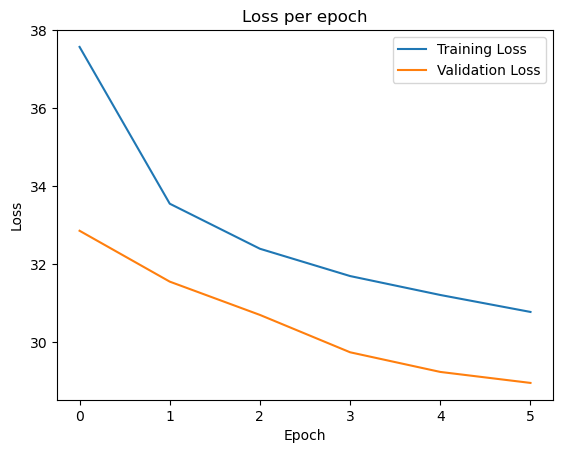

In [80]:
import matplotlib.pyplot as plt


# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per epoch')
plt.legend()
plt.show()

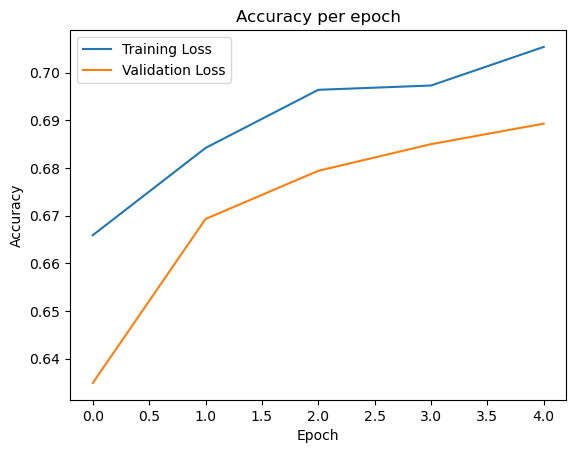

In [42]:
# Plot training and validation accuracies
plt.plot(val_accuracies, label='Training Accuracy')
plt.plot(train_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per epoch')
plt.legend()
plt.show()


In [81]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

model.eval()
all_true_labels = []
all_predicted_labels = []
with torch.no_grad():
    for input_text, context, labels in test_loader:
        input_text = {
            'input_ids': input_text['input_ids'].squeeze(1),
            'attention_mask': input_text['attention_mask'].squeeze(1),
            'token_type_ids': input_text['token_type_ids'].squeeze(1)
            }
        labels = labels.to(device)
        output = model(input_ids=input_text['input_ids'].squeeze(1), 
                       attention_mask=input_text['attention_mask'].squeeze(1), 
                       token_type_ids=input_text['token_type_ids'].squeeze(1))

        # Store true and predicted labels for this batch
        predicted_labels = output.argmax(dim=1)
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted_labels.cpu().numpy())

# Calculate precision, recall, F1-score, and support
precision, recall, f1_score, support = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted', zero_division=0)

# Create a DataFrame with the metrics
metrics_data = {
    'Weighted Avg Precision': [precision],
    'Weighted Avg Recall': [recall],
    'Weighted Avg F1-score': [f1_score],
}


metrics_df = pd.DataFrame(metrics_data)

# Display the metrics DataFrame
print(metrics_df)



   Weighted Avg Precision  Weighted Avg Recall  Weighted Avg F1-score
0                0.651422             0.660833               0.637154


In [82]:
model.eval()
test_loss = 0
test_acc = 0
with torch.no_grad():
    for input_text, context,labels in test_loader:
        input_text = {
            'input_ids': input_text['input_ids'].squeeze(1),
            'attention_mask': input_text['attention_mask'].squeeze(1),
            'token_type_ids': input_text['token_type_ids'].squeeze(1)
            }
        labels = labels.to(device)
        output = model(input_ids=input_text['input_ids'].squeeze(1), 
                       attention_mask=input_text['attention_mask'].squeeze(1), 
                       token_type_ids=input_text['token_type_ids'].squeeze(1))
        loss = criterion(output, labels)

        test_loss += loss.item() * input_text["input_ids"].size(0)

        # Compute accuracy for this batch
        predicted_labels = output.argmax(dim=1)
        num_correct = (predicted_labels == labels).sum().item()
        acc = num_correct / len(labels)
        test_acc += acc

# Compute average test loss and accuracy
test_loss /= len(test_loader)
test_acc /= len(test_loader)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')


Test Loss: 33.2205, Test Accuracy: 0.6598
